Spam filtering using Naive Bayes Classification

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import string
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict as dd
import math

#To remove warning message clutter:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Read the dataset into a dataframe and explore

In [4]:

(os.chdir(r"C:\Users\Alim\Desktop\Uni\13212Lab5"))
df = pd.read_csv("spam.csv", encoding="latin-1")


## 2. Clean the data

In [5]:
df['v2'].str.replace('[{}]'.format(string.punctuation), '')
df = df.replace('[^a-zA-Z0-9 ]', '', regex=True)
df["v2"] = df["v2"].str.lower()
df['v2'] = df['v2'].str.replace('\d+', '')
clean = df.copy()

## 3. Split the Data

In [6]:
train_data = df.sample(frac = 0.75, random_state = 42)
test_data = df.drop(train_data.index)

## 4. Create a Word Frequency Dataframe

In [7]:
spam_df = pd.DataFrame()
ham_df = pd.DataFrame()
for i in range(len(df)):
    if df["v1"][i] == "ham":
        current_ham = df.iloc[i]
        ham_df = ham_df.append(current_ham, ignore_index=False, verify_integrity=False, sort=False)
    elif df["v1"][i] == "spam":
        current_spam = df.iloc[i]
        spam_df = spam_df.append(current_spam, ignore_index=False, verify_integrity=False, sort=False)
    else:
        print("error")

words = []
for word in clean["v2"]:
    words.extend(word.split())

sentences = []
for word in clean["v2"]:
    sentences.append(word.split())        

spam = dd(int)
ham = dd(int)
for i in range(len(sentences)):
    if df['v1'][i] == 'ham':
        for x in sentences[i]:
            ham[x] += 1
    else:
        for x in sentences[i]:
            spam[x] += 1

answer = []

for x in spam:
    answer.append([x,spam[x],ham[x]])

for x in ham:
    if x not in spam:
        answer.append([x,spam[x],ham[x]])

sortedAnswer = sorted(answer,key=lambda l:l[2], reverse=True)


word_freq = pd.DataFrame(sortedAnswer)
word_freq.columns = ["Word", "#Spam", "#Ham"]

print(word_freq)

           Word  #Spam  #Ham
0             i     54  2185
1           you    287  1837
2            to    686  1554
3           the    204  1119
4             a    378  1055
...         ...    ...   ...
8534  chatlines      1     0
8535      inclu      1     0
8536      servs      1     0
8537        ler      1     0
8538    bailiff      1     0

[8539 rows x 3 columns]


## 5. Visualise the Data

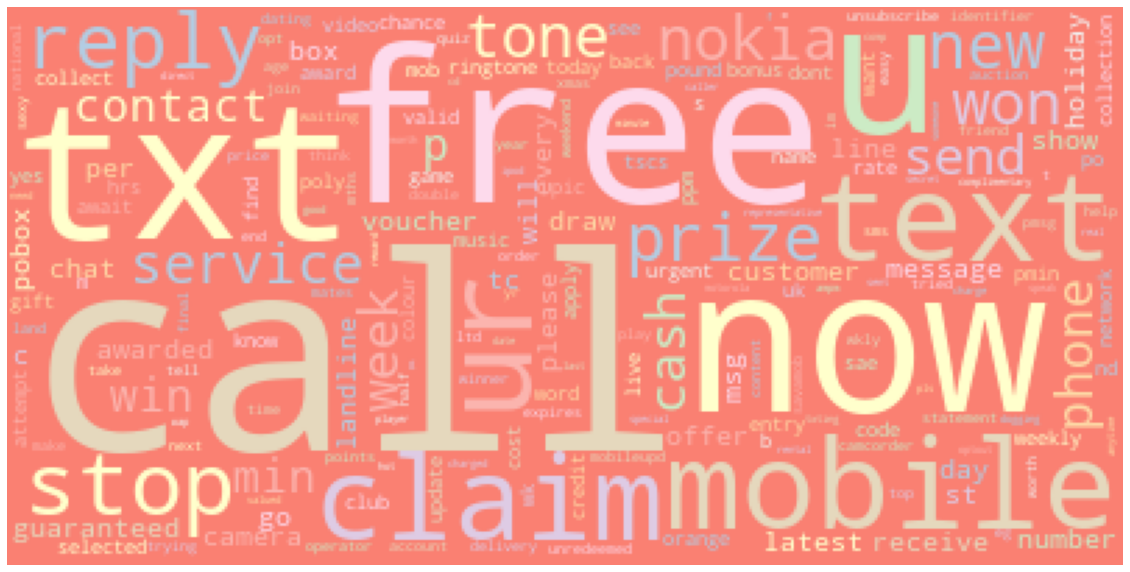

In [8]:
string = ""
for v2msg in spam_df["v2"]:
    string = string + str(v2msg)

wordcloud = WordCloud(background_color='salmon', colormap='Pastel1', collocations=False).generate(string)
plt.figure(figsize=(20, 15))
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

## 6. Calculate 𝑃(𝐸|𝑆) and 𝑃(𝐸|¬𝑆)

In [9]:
k = 0.5
df_word_prob = []

for i in range(len(word_freq)):
    word = word_freq["Word"][i]
    spam_prob = (float(word_freq.iloc[i][1]) + k) / (0.75*747 + 2*k)
    ham_prob = (float(word_freq.iloc[i][2]) + k) / (0.75*4825 + 2*k)
    df_word_prob.append([word, spam_prob, ham_prob])
word_prob = pd.DataFrame(df_word_prob)
word_prob.columns = ["Word", "P(E|S)", "P(E|¬S)"]
print(word_prob)

           Word    P(E|S)   P(E|¬S)
0             i  0.097105  0.603771
1           you  0.512249  0.507632
2            to  1.223163  0.429450
3           the  0.364365  0.309276
4             a  0.674388  0.291595
...         ...       ...       ...
8534  chatlines  0.002673  0.000138
8535      inclu  0.002673  0.000138
8536      servs  0.002673  0.000138
8537        ler  0.002673  0.000138
8538    bailiff  0.002673  0.000138

[8539 rows x 3 columns]


## 7. Checking the 'spamliness' of a single word

In [10]:
def check_spamliness(df, word):
    prior_spam = 0.135
    prior_ham = 0.865
    selected_word_row = df.loc[df['Word'] == word]
    PE_given_S = selected_word_row.iloc[0][1]
    PE_given_notS = selected_word_row.iloc[0][2]
    numerator = PE_given_S * prior_spam
    denominator = (math.log(PE_given_S + prior_spam)) + (math.log(PE_given_notS + prior_ham))
    #9. Avoiding floating point underflow
    print("Word = " + word)
    print("P(E|S) = " + str(PE_given_S))
    print("P(E|¬S) = " + str( PE_given_notS))
    print("P(S|E) = " + str((numerator/denominator)))
    print("P(¬S|E) = " + str((1 - (numerator/denominator))))
    return (numerator/denominator)

## 8. Checking the 'spamliness' of several words

In [11]:
def spam_or_ham(message):
    spamliness_list = []
    hamliness_list = []

    for i in str(message).split(" "):
        if any(i in sl for sl in sortedAnswer):
            spamliness_list.append(check_spamliness(word_prob, i))
            hamliness_list.append(1-(check_spamliness(word_prob, i)))

    spamliness_msg = np.prod(spamliness_list)
    hamliness_msg = np.prod(hamliness_list)

    if spamliness_msg > hamliness_msg:
        return False
    elif hamliness_msg > spamliness_msg:
        return True

## 10. Testing the Model

This takes some time as the spamliness of each word is outputted along with the final results.

In [12]:
match_spam = 0
match_ham = 0
thought_ham_is_spam = 0
thought_spam_is_ham = 0
Accuracy = 0

for i in range(len(test_data)):
    message = test_data.iloc[i][1] 
    if spam_or_ham(message) and test_data.iloc[i][0] == "ham":
        match_ham += 1
    elif spam_or_ham(message) and test_data.iloc[i][0] != "ham":
        thought_spam_is_ham += 1
    elif not(spam_or_ham(message)) and test_data.iloc[i][0] != "ham":
        match_spam += 1
    else:
        thought_ham_is_spam += 1
Accuracy = (match_ham + match_spam)/(match_ham + match_spam + thought_ham_is_spam + thought_spam_is_ham)
print("match_spam: " + str(match_spam))
print("match_ham: " + str(match_ham))
print("thought_ham_is_spam: " + str(thought_ham_is_spam))
print("thought_spam_is_ham: " + str(thought_spam_is_ham))
print("Accuracy: " + str(Accuracy))

Word = free
P(E|S) = 0.3910913140311804
P(E|¬S) = 0.01643759928171835
P(S|E) = -0.06870344178914131
P(¬S|E) = 1.0687034417891412
Word = free
P(E|S) = 0.3910913140311804
P(E|¬S) = 0.01643759928171835
P(S|E) = -0.06870344178914131
P(¬S|E) = 1.0687034417891412
Word = entry
P(E|S) = 0.04721603563474387
P(E|¬S) = 0.00013813108640099454
P(S|E) = -0.003450290615279514
P(¬S|E) = 1.0034502906152796
Word = entry
P(E|S) = 0.04721603563474387
P(E|¬S) = 0.00013813108640099454
P(S|E) = -0.003450290615279514
P(¬S|E) = 1.0034502906152796
Word = in
P(E|S) = 0.13273942093541202
P(E|¬S) = 0.2247392775744181
P(S|E) = -0.014547640750352416
P(¬S|E) = 1.0145476407503524
Word = in
P(E|S) = 0.13273942093541202
P(E|¬S) = 0.2247392775744181
P(S|E) = -0.014547640750352416
P(¬S|E) = 1.0145476407503524
Word = a
P(E|S) = 0.6743875278396436
P(E|¬S) = 0.2915947233924995
P(S|E) = -1.379484396647006
P(¬S|E) = 2.379484396647006
Word = a
P(E|S) = 0.6743875278396436
P(E|¬S) = 0.2915947233924995
P(S|E) = -1.379484396647006
